<center><h1> (Alternative) ODE Time Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats, linalg
from scipy.stats import distributions as dist
from mud import std_from_equipment
# from mud import full_functional, norm_input, norm_data, norm_predicted,  
# from mud import make_2d_unit_mesh

In [2]:
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['font.size']      = 16
fsize                          = 32

# Define Inputs/Outputs to Model

In [3]:
lam_true = 0.5
def makeDecayModel(t):
    def model(lam = np.array([[lam_true]]) ):
        if isinstance(lam, float) or isinstance(lam, int):
            lam = np.array([[lam]])
        initial_cond = 0.75
        rate = lam[:,0].reshape(-1,1)
        response = initial_cond*np.exp(np.outer(rate, -t))
        if response.shape[0] == 1:
            return response.ravel() # this allows support for simpler 1D plotting.
        else:
            return response
    return model

---

# Define Measurements / Reference Solution

In [4]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
start_time = 1
end_time   = 3
tolerance  = 0.1 # precision of measurement equipment
meas_hertz = 200 # times per second observations are made
num_trials = 20  # realizations of synthetic data for numerical runs
################
# Processing the settings above
################
num_measure     = meas_hertz*(end_time-start_time)
time_vector     = np.linspace(start_time, end_time, num_measure)
sigma           = std_from_equipment(tolerance=tolerance, probability=0.99)
model           = makeDecayModel(time_vector)
qoi_true        = model() # no args evaluates true param
####

In [5]:
sensors = time_vector

---

## Create input / output sets

We fix our exploratory samples of the parameter space $\Lambda$ for all experiments.


In [6]:
num_samples = 1E4
np.random.seed(21)
lam = np.random.rand(int(num_samples)).reshape(-1,1)
a = np.argsort(lam.ravel())
qoi = model(lam)

In [7]:
qoi.shape

(10000, 400)

---
---

# Solve Inverse Problem

In [8]:
import bet.sample as samp

In [9]:
def mud_problem(lam, qoi, sd=sigma, num_obs=None, qoi_true=qoi_true):
    try:
        dim_input = lam.shape[1]
    except IndexError:
        dim_input = 1

    try:
        dim_output = qoi.shape[1]
    except IndexError:
        dim_output = 1

    if num_obs is None:
        num_obs = dim_output
    elif num_obs < 1:
        raise ValueError("num_obs must be >= 1")
    elif num_obs > dim_output:
        raise ValueError("num_obs must be <= dim(qoi)")

    i_set = samp.sample_set(dim_input)
    i_set.set_domain(np.array([[0,1]])) # TODO: generalize domain
    
    i_set.set_values(lam)
    o_set = samp.sample_set(dim_output)
    o_set.set_values(qoi)
    d = samp.discretization(i_set, o_set)
    data = qoi_true[0:num_obs] + np.random.randn(num_obs)*sd
    
    # TODO generalize
    d.set_initial(dist=dist.uniform(loc=0,scale=1), gen=False)
    # needed if changing dimensions around until fix is made in BET
#     d._output_probability_set = None # will throw warning
    d._output_probability_set = samp.sample_set(num_obs)
    d.data_driven(data=data, std=sd, inds=list(range(0,num_obs)))
    return d

# What happens as we take more observations?

## Make MUD solutions for successive inclusions of measurements

We take repeated trials (draws of noise polluting our data) to study the sensitivity to individual experiments as a function of number of observations.

In [10]:
prefix = 'ode-alt'
num_sensor_list = np.arange(num_measure) + 1
# num_sensors_plot_conv = num_sensor_list[4::5]
# num_sensors_plot_conv = num_sensor_list[9::10]
# num_sensors_plot_conv = num_sensor_list[24::25]
num_sensors_plot_conv = [5, 10, 15, 20, 25, 50, 100, 200, 400]

print(f"Will run simulations for {num_sensors_plot_conv}")

Will run simulations for [5, 10, 15, 20, 25, 50, 100, 200, 400]


In [11]:
%%time
experiments = {}
solutions = {}
for ns in num_sensors_plot_conv:
    discretizations = []
    mud_solutions = []
    for t in range(num_trials):
        np.random.seed(21+t)
        _d = mud_problem(lam, qoi, sd=sigma, num_obs=ns)
        discretizations.append(_d)
        mud_solutions.append(_d.mud_point())
    experiments[ns] = discretizations
    solutions[ns] = mud_solutions

CPU times: user 7min 55s, sys: 1.08 s, total: 7min 56s
Wall time: 7min 56s


## extract means and variances from repeated trials

In [12]:
means = []
variances = []
for ns in num_sensors_plot_conv:
    mud_solutions = solutions[ns]
    err = np.abs(np.array(mud_solutions) - lam_true)
    mean_mud_sol = np.mean(err)
    var_mud_sol = np.var(err)
    means.append(mean_mud_sol)
    variances.append(var_mud_sol)

## How does the accuracy + precision change?

In [13]:
x, ym, yv = np.log10(num_sensors_plot_conv), np.log10(means), np.log10(variances)

slope_mean, intercept_mean = (np.linalg.pinv(np.vander(x, 2))@np.array(ym).reshape(-1,1)).ravel()
slope_var, intercept_var = (np.linalg.pinv(np.vander(x, 2))@np.array(yv).reshape(-1,1)).ravel()

regression_mean = slope_mean*x + intercept_mean
regression_var  = slope_var*x + intercept_var

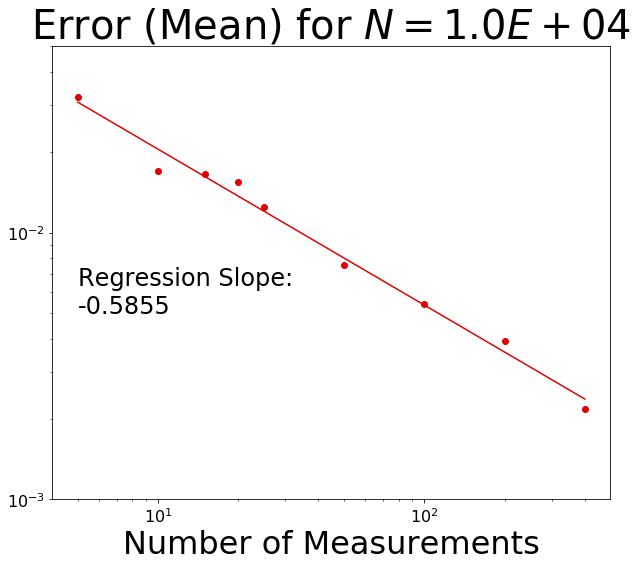

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(num_sensors_plot_conv, means, label='mean', c='xkcd:red')
plt.plot(num_sensors_plot_conv, 10**regression_mean, c='xkcd:red')
plt.annotate(f"Regression Slope:\n{slope_mean:1.4f}", (num_sensors_plot_conv[0],0.005), fontsize=24)

plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(1E-3,5E-2)
plt.xlabel('Number of Measurements', fontsize=fsize)
# plt.ylabel('Absolute Error in MUD', fontsize=fsize)
plt.title(f"Error (Mean) for $N={lam.shape[0]:1.1E}$", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_obs_mean.pdf', bbox_inches='tight')
plt.show()

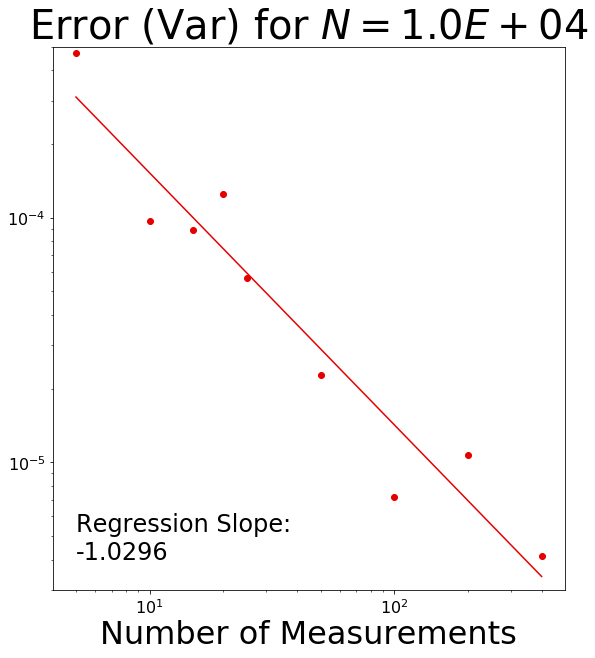

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(num_sensors_plot_conv, variances, label='variance', c='xkcd:red')
plt.plot(num_sensors_plot_conv, 10**regression_var, c='xkcd:red')
plt.annotate(f"Regression Slope:\n{slope_var:1.4f}", (num_sensors_plot_conv[0], 4E-6), fontsize=24)

plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(3E-6, 5E-4)
plt.xlabel('Number of Measurements', fontsize=fsize)
# plt.ylabel('Absolute Error in MUD', fontsize=fsize)
plt.title(f"Error (Var) for $N={lam.shape[0]:1.1E}$", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_obs_var.pdf')
plt.show()

---

## Measurement Error

Fixed number of sensors, varying the quality of equipment.


In [16]:
%%time
sd_err = []
sd_var = []
tolerances = [0.1, 0.05, 0.01, 0.005, 0.001]
sd_vals = [ std_from_equipment(tolerance=tol, probability=0.99) for tol in tolerances ]

num_sensors = 25
for sd in sd_vals:
    temp_err = []
    for t in range(num_trials):
        d = mud_problem(lam, qoi, sd=sd, qoi_true=qoi_true, num_obs=num_sensors)
        mud_point = d.mud_point()
        temp_err.append(np.abs(mud_point - lam_true))
    sd_err.append(np.mean(temp_err))
    sd_var.append(np.var(temp_err))

CPU times: user 4min 24s, sys: 18.4 ms, total: 4min 24s
Wall time: 4min 25s


In [17]:
xx, yym, yyv = np.log10(sd_vals), np.log10(sd_err), np.log10(sd_var)

slope_err_mean, intercept_err_mean = (np.linalg.pinv(np.vander(xx, 2))@np.array(yym).reshape(-1,1)).ravel()
slope_err_var, intercept_err_var = (np.linalg.pinv(np.vander(xx, 2))@np.array(yyv).reshape(-1,1)).ravel()

regression_err_mean = slope_err_mean*xx + intercept_err_mean
regression_err_var  = slope_err_var*xx + intercept_err_var

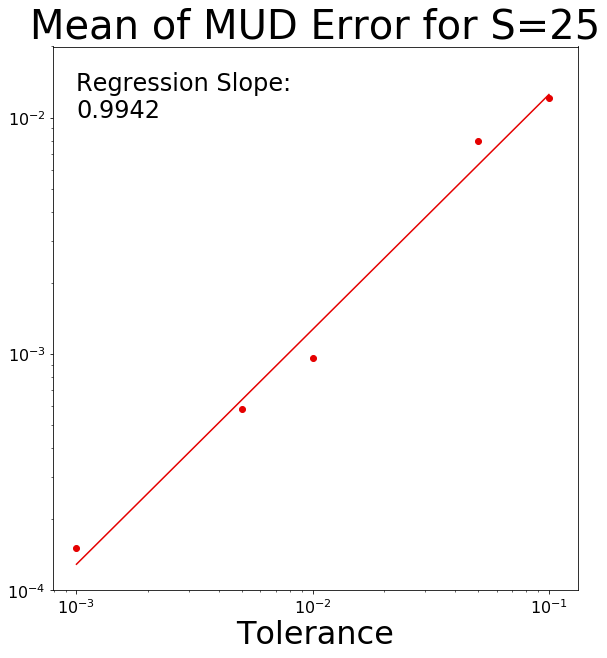

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(tolerances, sd_err, label='mean', c='xkcd:red')
plt.plot(tolerances, 10**regression_err_mean, label='mean', c='xkcd:red')
# plt.plot(sd_vals, np.power(np.array(sd_vals), 1), label='$\sigma$', ls='--',  c='xkcd:red')

plt.annotate(f"Regression Slope:\n{slope_err_mean:1.4f}", (tolerances[-1],1E-2), fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(1E-4, 2E-2)
# plt.ylabel("Absolute Error", fontsize=fsize)
plt.xlabel("Tolerance", fontsize=fsize)
plt.title(f"Mean of MUD Error for S={num_sensors}", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_std_mean.pdf')
plt.show()

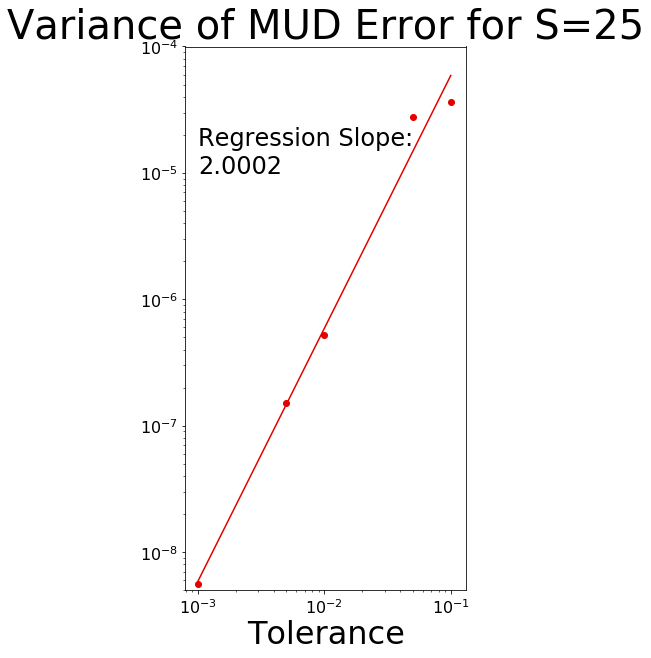

In [19]:
plt.figure(figsize=(10,10))

plt.scatter(tolerances, sd_var, label='mean', c='xkcd:red')
plt.plot(tolerances, 10**regression_err_var, label='mean', c='xkcd:red')
# plt.plot(sd_vals, np.power(np.array(sd_vals), 2), label='$\sigma^2$', ls='--', c='xkcd:red')
plt.annotate(f"Regression Slope:\n{slope_err_var:1.4f}", (tolerances[-1],1E-5), fontsize=24)
plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(5E-9, 1E-4)
# plt.xlim(1E-3, 1E-1)

# plt.ylabel("Absolute Error", fontsize=fsize)
plt.xlabel("Tolerance", fontsize=fsize)
plt.title(f"Variance of MUD Error for S={num_sensors}", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_std_var.pdf')
plt.show()

---

# Visualize Reference Solution

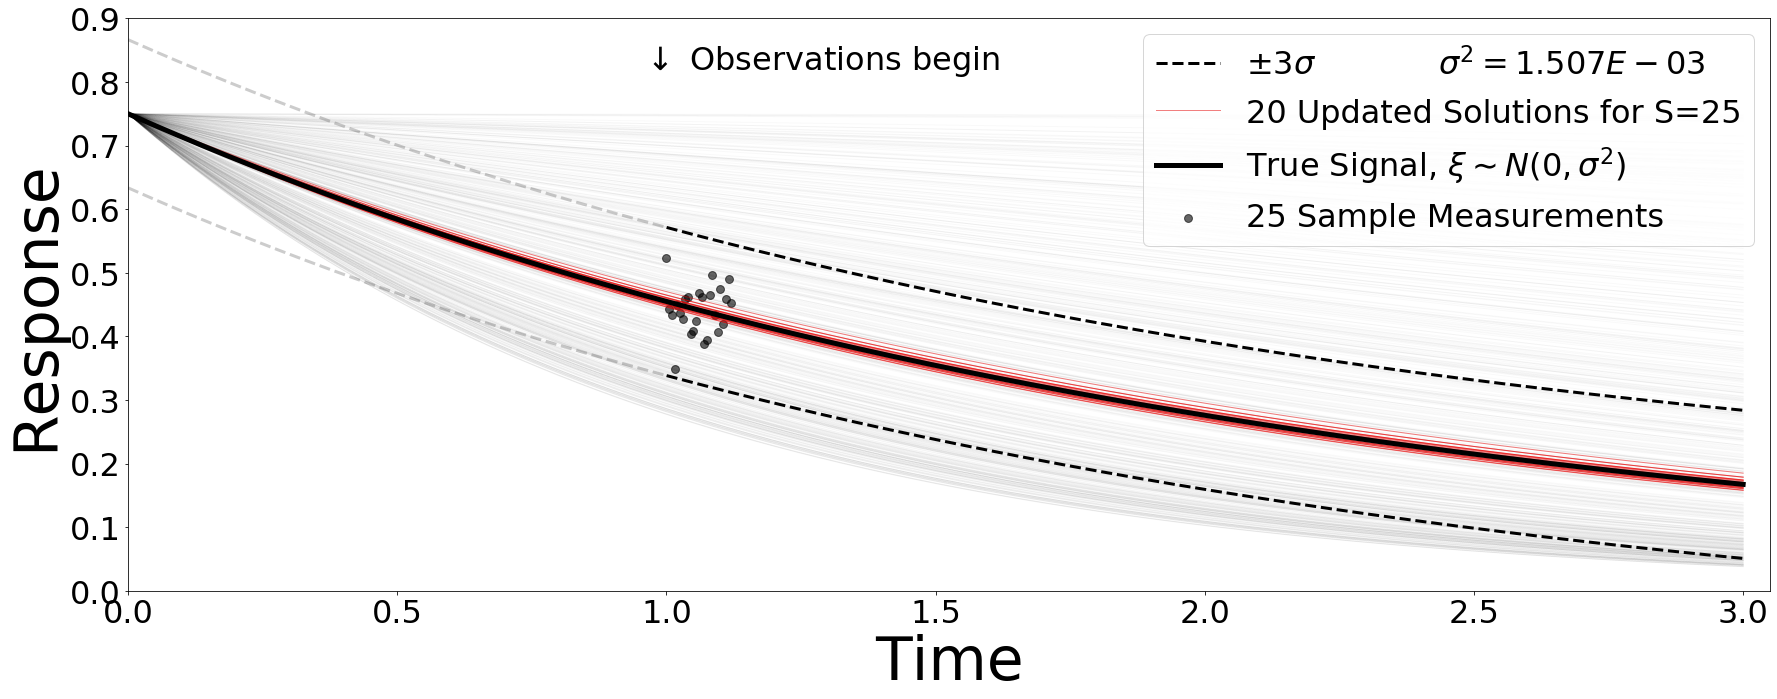

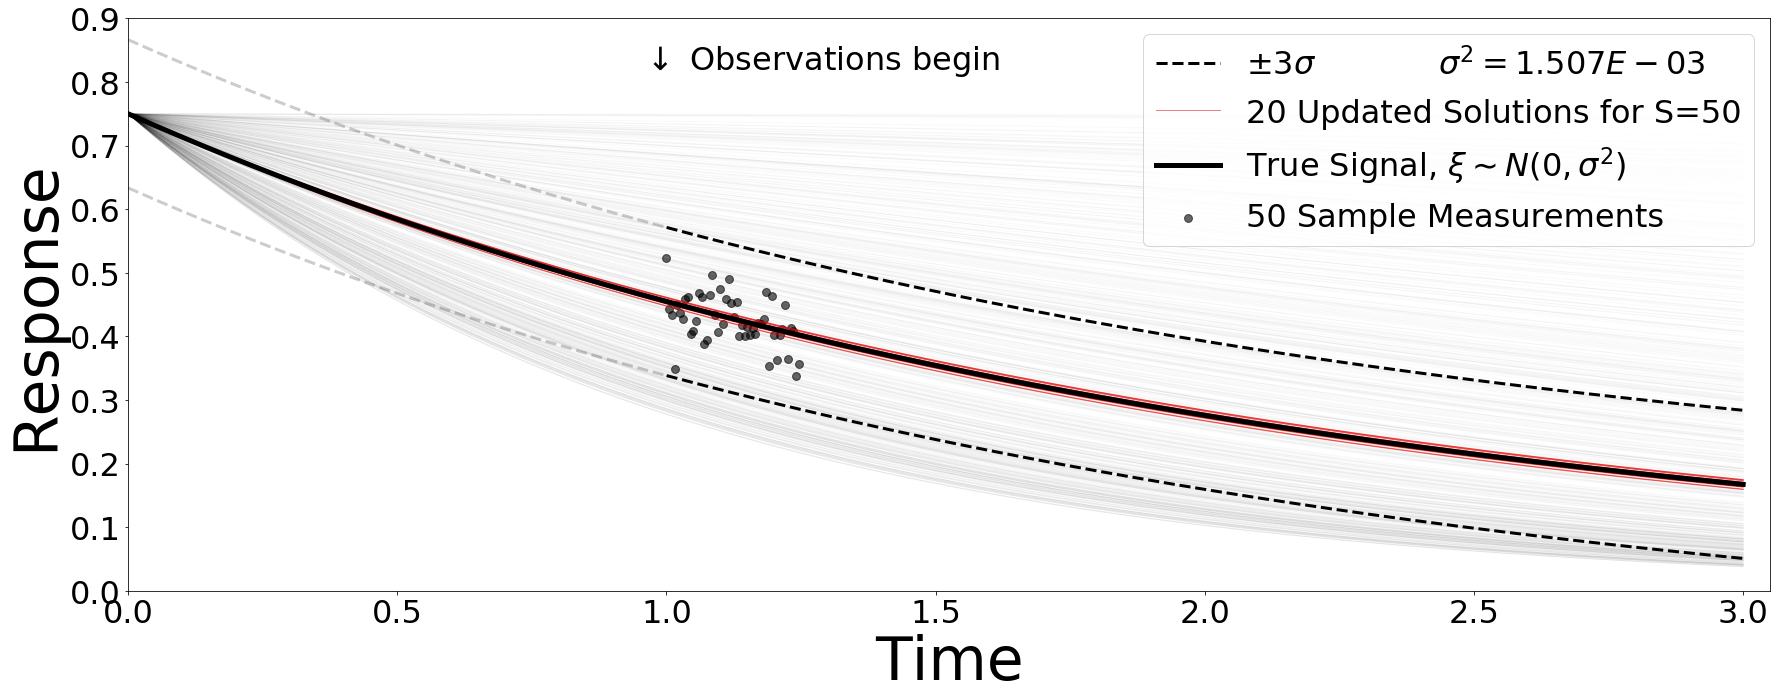

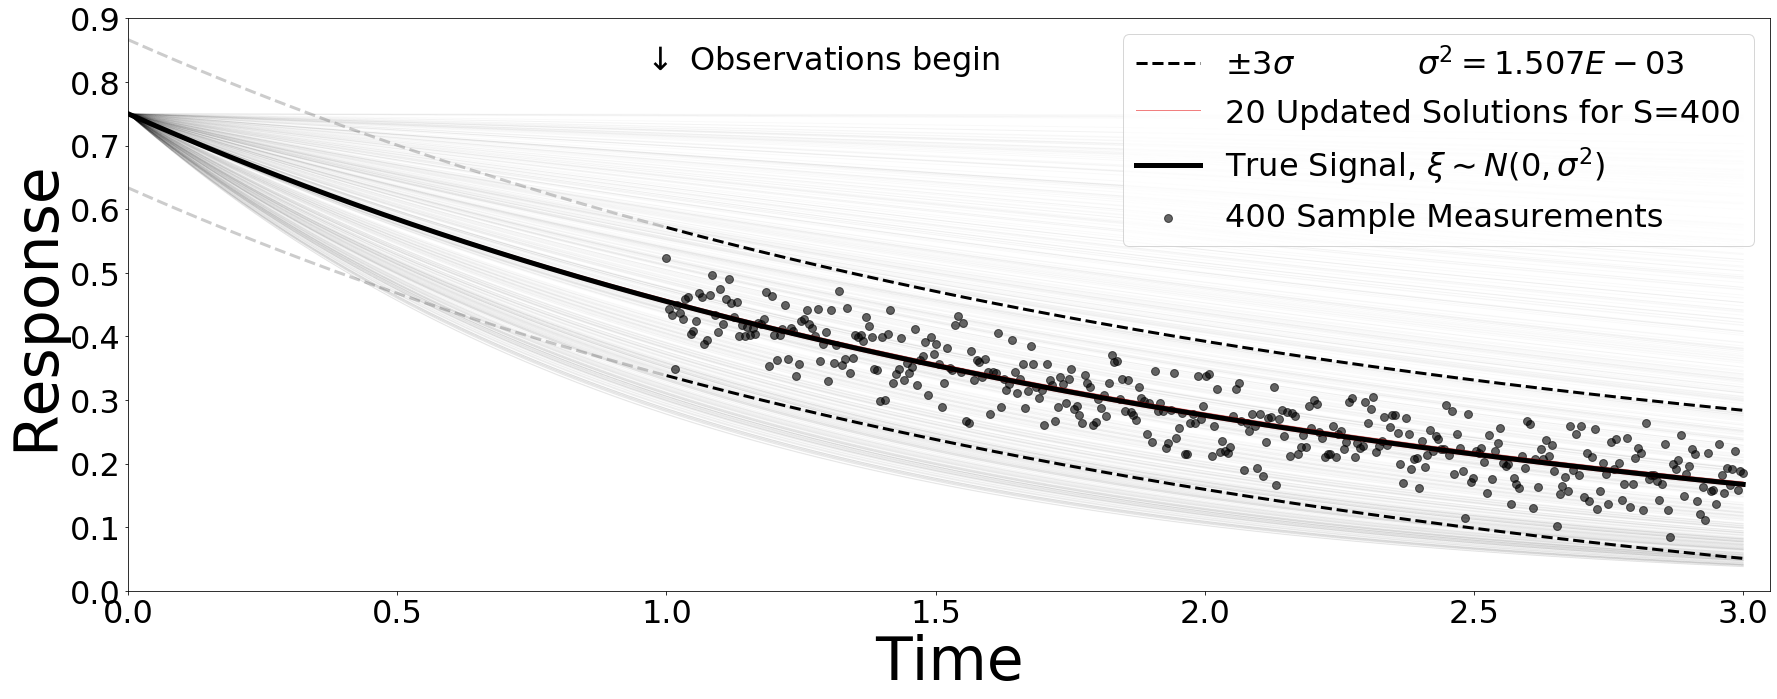

In [20]:
alpha_signal = 0.2
alpha_points = 0.6
num_meas_plot_list = [25, 50, 400]

for num_meas_plot in num_meas_plot_list:
    filename = f'{prefix}_{num_meas_plot}_reference_solution.pdf'
    plt.rcParams['figure.figsize'] = 25,10
    fig = plt.figure()

    plotting_mesh = np.linspace(0, end_time, 1000*end_time)
    plot_model = makeDecayModel(plotting_mesh)
    true_response = plot_model() # no args evaluates true param


    # sample signals
    num_sample_signals  = 500
    alpha_signal_sample = 0.025
    for i in range(num_sample_signals):
        _true_response = plot_model(lam[i,0]) # uniform(0,1) draws from parameter space
        plt.plot(plotting_mesh, _true_response, lw=1, c='k', alpha=alpha_signal_sample)

    # error bars
    sigma_label = f"$\\pm3\\sigma \qquad\qquad \\sigma^2={sigma**2:1.3E}$"
    plt.plot(plotting_mesh[1000:], true_response[1000:]+3*sigma, ls='--', lw=3, c='xkcd:black', alpha=1)
    plt.plot(plotting_mesh[1000:], true_response[1000:]-3*sigma, ls='--', lw=3, c='xkcd:black', alpha=1, label=sigma_label)
    plt.plot(plotting_mesh[:1000], true_response[:1000]+3*sigma, ls='--', lw=3, c='xkcd:black', alpha=alpha_signal)
    plt.plot(plotting_mesh[:1000], true_response[:1000]-3*sigma, ls='--', lw=3, c='xkcd:black', alpha=alpha_signal)

    # solutions
    mud_solutions = solutions[num_meas_plot]
    plt.plot(plotting_mesh, plot_model(mud_solutions[0][0]), lw=1, c='xkcd:red', alpha=20*alpha_signal_sample, label=f'{len(mud_solutions)} Updated Solutions for S={num_meas_plot}')
    for _lam in mud_solutions[1:]:
        _true_response = plot_model(_lam[0])
        plt.plot(plotting_mesh, _true_response, lw=1, c='xkcd:red', alpha=20*alpha_signal_sample)


    # true signal
    plt.plot(plotting_mesh, true_response, lw=5, c='k', alpha=1, label="True Signal, $\\xi \\sim N(0, \\sigma^2)$")


    # observations
    np.random.seed(11)
    annotate_height = 0.82
    u = model() + np.random.randn(len(time_vector))*sigma
    plot_num_measure = num_meas_plot
    plt.scatter(time_vector[:plot_num_measure], u[:plot_num_measure], color='k', marker='.', s=250, alpha=alpha_points, label=f'{num_meas_plot} Sample Measurements')
    plt.annotate("$ \\downarrow$ Observations begin", (0.95,annotate_height), fontsize=fsize)
#     plt.annotate("$\\downarrow$ Possible Signals", (0,annotate_height), fontsize=fsize)


    plt.ylim([0,0.9])
    plt.xlim([0,end_time+.05])
    plt.ylabel('Response', fontsize=60)
    plt.xlabel('Time', fontsize=60)
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.legend(fontsize=fsize, loc='upper right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [21]:
!git add -f {prefix}_convergence_mud_std_mean.pdf
!git add -f {prefix}_convergence_mud_std_var.pdf
!git add -f {prefix}_convergence_mud_obs_mean.pdf
!git add -f {prefix}_convergence_mud_obs_var.pdf
for num_meas_plot in num_meas_plot_list:
    filename = f'{prefix}_{num_meas_plot}_reference_solution.pdf'
    print(filename)
    !git add -f {filename}

ode-alt_25_reference_solution.pdf
ode-alt_50_reference_solution.pdf
ode-alt_400_reference_solution.pdf
